In [ ]:
!pip install -q evaluate transformers datasets mlflow

In [30]:
# imports
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             classification_report, 
                             f1_score)

import evaluate
from datasets import Dataset, Image
from transformers import (TrainingArguments, 
                          Trainer, 
                          ViTImageProcessor, 
                          ViTForImageClassification,
                          DefaultDataCollator)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)

Total files found: 94110
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x1F6806F04A0>


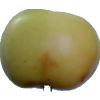

In [33]:
from pathlib import Path
from datasets import Dataset, Image

# Check the correct path and update accordingly
base_path = Path('archive/fruits-360_dataset_100x100/fruits-360')

# Adjust glob pattern if necessary
file_names = [str(file) for file in base_path.glob('**/*.jpg')]
labels = [file.parent.name for file in base_path.glob('**/*.jpg')]  # parent directory as label

# Check if files are being found
print(f"Total files found: {len(file_names)}")

if len(file_names) > 0:
    dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())
    print(dataset[0]["image"])
else:
    print("No files found. Please check the directory path and file pattern.")

dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())
dataset[0]["image"]

In [34]:
labels_list = list(set(labels))
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'Peach Flat 1', 1: 'Potato White 1', 2: 'Pineapple Mini 1', 3: 'Tomato not Ripened 1', 4: 'Ginger Root 1', 5: 'Pear Forelle 1', 6: 'Apple Pink Lady 1', 7: 'Tomato 1', 8: 'Granadilla 1', 9: 'Pepino 1', 10: 'Pepper Green 1', 11: 'Pepper Yellow 1', 12: 'Grape White 2', 13: 'Nectarine 1', 14: 'Cucumber 3', 15: 'Potato Sweet 1', 16: 'Avocado ripe 1', 17: 'Maracuja 1', 18: 'Fig 1', 19: 'Tomato 4', 20: 'Chestnut 1', 21: 'Eggplant 1', 22: 'Salak 1', 23: 'Apple Red 2', 24: 'Banana 1', 25: 'Mangostan 1', 26: 'Pear 3', 27: 'Cucumber Ripe 1', 28: 'Cabbage white 1', 29: 'Apple Golden 1', 30: 'Apple Red Yellow 2', 31: 'Plum 1', 32: 'Carambula 1', 33: 'Corn 1', 34: 'Cauliflower 1', 35: 'Cucumber 1', 36: 'Apple Red Delicious 1', 37: 'Passion Fruit 1', 38: 'Rambutan 1', 39: 'Grape Blue 1', 40: 'Grape Pink 1', 41: 'Quince 1', 42: 'Grape White 3', 43: 'Melon Piel de Sapo 1', 44: 'Tomato 3', 45: 'Tomato Heart 1', 46: 'Peach 1', 47: 'Apple Golden 3', 48: 'Kaki 1', 49: 'Kumquats 1', 50: 'Grape White 4',

In [35]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 94110
})

In [36]:
dataset = dataset.train_test_split(test_size=0.3)
train_data = dataset['train']
test_data = dataset['test']

In [37]:
train_data[2]['label']

'Apple Red Yellow 1'

In [38]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [39]:
# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [40]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Load model

In [41]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.907085


In [42]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    
    return {
        "accuracy": acc_score
    }

In [ ]:
# !pip install transformers[torch]


In [47]:
# !pip install accelerate>=0.26.0


In [ ]:
# !pip install accelerate --upgrade


In [53]:
import accelerate
print(accelerate.__version__)


1.2.1


In [43]:
# from transformers import TrainingArguments


metric_name = "accuracy"
model_name = "fruits_type_detection"
num_train_epochs=3
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

In [44]:
# from transformers import Trainer, TrainingArguments

# Assume the other variables (train_data, test_data, collate_fn, compute_metrics) are already defined



trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)



In [45]:
trainer.evaluate()

100%|██████████| 7059/7059 [08:51<00:00, 13.28it/s]


{'eval_loss': 4.956243515014648,
 'eval_model_preparation_time': 0.014,
 'eval_accuracy': 0.005702546665249885,
 'eval_runtime': 531.7654,
 'eval_samples_per_second': 53.093,
 'eval_steps_per_second': 13.275}

In [46]:
trainer.train()

  8%|▊         | 500/6177 [07:59<1:26:02,  1.10it/s]

{'loss': 4.405, 'grad_norm': 2.0978305339813232, 'learning_rate': 9.265545944181491e-06, 'epoch': 0.24}


 16%|█▌        | 1000/6177 [15:32<1:20:42,  1.07it/s]

{'loss': 3.3666, 'grad_norm': 2.228644609451294, 'learning_rate': 8.449485882160928e-06, 'epoch': 0.49}


 24%|██▍       | 1500/6177 [23:00<1:09:06,  1.13it/s]

{'loss': 2.6635, 'grad_norm': 2.1941699981689453, 'learning_rate': 7.633425820140363e-06, 'epoch': 0.73}


 32%|███▏      | 2000/6177 [30:22<1:03:13,  1.10it/s]

{'loss': 2.1634, 'grad_norm': 2.035588502883911, 'learning_rate': 6.817365758119798e-06, 'epoch': 0.97}


 33%|███▎      | 2059/6177 [36:00<50:38,  1.36it/s]

{'eval_loss': 2.015259265899658, 'eval_model_preparation_time': 0.014, 'eval_accuracy': 0.9998583218219814, 'eval_runtime': 284.956, 'eval_samples_per_second': 99.078, 'eval_steps_per_second': 24.772, 'epoch': 1.0}


 40%|████      | 2500/6177 [40:44<38:16,  1.60it/s]   

{'loss': 1.7781, 'grad_norm': 1.8502498865127563, 'learning_rate': 6.001305696099233e-06, 'epoch': 1.21}


 49%|████▊     | 3000/6177 [45:59<32:55,  1.61it/s]

{'loss': 1.4886, 'grad_norm': 1.6700986623764038, 'learning_rate': 5.185245634078668e-06, 'epoch': 1.46}


 57%|█████▋    | 3500/6177 [51:17<28:10,  1.58it/s]

{'loss': 1.2633, 'grad_norm': 1.7352547645568848, 'learning_rate': 4.369185572058104e-06, 'epoch': 1.7}


 65%|██████▍   | 4000/6177 [56:40<23:29,  1.54it/s]

{'loss': 1.0903, 'grad_norm': 1.695443034172058, 'learning_rate': 3.5531255100375387e-06, 'epoch': 1.94}


                                                   
 67%|██████▋   | 4118/6177 [1:02:31<18:36,  1.84it/s]

{'eval_loss': 1.0509322881698608, 'eval_model_preparation_time': 0.014, 'eval_accuracy': 0.9999645804554953, 'eval_runtime': 275.1461, 'eval_samples_per_second': 102.611, 'eval_steps_per_second': 25.655, 'epoch': 2.0}


 73%|███████▎  | 4500/6177 [1:06:35<17:37,  1.59it/s]   

{'loss': 0.9649, 'grad_norm': 1.366652011871338, 'learning_rate': 2.7370654480169746e-06, 'epoch': 2.19}


 81%|████████  | 5000/6177 [1:11:52<12:25,  1.58it/s]

{'loss': 0.8755, 'grad_norm': 1.2322407960891724, 'learning_rate': 1.9210053859964096e-06, 'epoch': 2.43}


 89%|████████▉ | 5500/6177 [1:17:07<07:09,  1.57it/s]

{'loss': 0.8116, 'grad_norm': 1.2140110731124878, 'learning_rate': 1.1049453239758446e-06, 'epoch': 2.67}


 97%|█████████▋| 6000/6177 [1:22:24<01:51,  1.59it/s]

{'loss': 0.7795, 'grad_norm': 1.2152786254882812, 'learning_rate': 2.8888526195527995e-07, 'epoch': 2.91}


100%|██████████| 6177/6177 [1:28:57<00:00,  1.86it/s]

{'eval_loss': 0.8162187933921814, 'eval_model_preparation_time': 0.014, 'eval_accuracy': 0.9999645804554953, 'eval_runtime': 279.7348, 'eval_samples_per_second': 100.928, 'eval_steps_per_second': 25.235, 'epoch': 3.0}


100%|██████████| 6177/6177 [1:28:59<00:00,  1.86it/s]

{'train_runtime': 5339.2819, 'train_samples_per_second': 37.015, 'train_steps_per_second': 1.157, 'train_loss': 1.7745227662417347, 'epoch': 3.0}


100%|██████████| 6177/6177 [1:29:00<00:00,  1.16it/s]


TrainOutput(global_step=6177, training_loss=1.7745227662417347, metrics={'train_runtime': 5339.2819, 'train_samples_per_second': 37.015, 'train_steps_per_second': 1.157, 'total_flos': 1.5333898801141832e+19, 'train_loss': 1.7745227662417347, 'epoch': 3.0})

In [47]:
trainer.evaluate()

100%|██████████| 7059/7059 [04:40<00:00, 25.18it/s]


{'eval_loss': 0.8162187933921814,
 'eval_model_preparation_time': 0.014,
 'eval_accuracy': 0.9999645804554953,
 'eval_runtime': 280.341,
 'eval_samples_per_second': 100.709,
 'eval_steps_per_second': 25.18,
 'epoch': 3.0}

In [48]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

100%|██████████| 7059/7059 [04:36<00:00, 25.49it/s]

{'test_loss': 0.8162187933921814, 'test_model_preparation_time': 0.014, 'test_accuracy': 0.9999645804554953, 'test_runtime': 277.2561, 'test_samples_per_second': 101.83, 'test_steps_per_second': 25.46}


In [49]:
%matplotlib inline

Accuracy: 1.0000
F1 Score: 1.0000


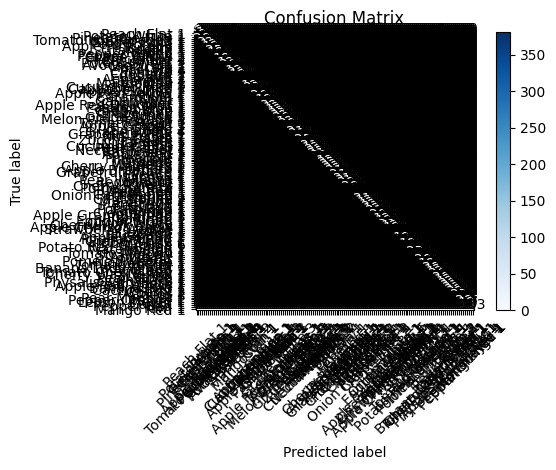

In [50]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.
    
    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels_list)

In [51]:
trainer.save_model()

In [52]:
from transformers import pipeline

pipe = pipeline('image-classification',model=model_name,device=0)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


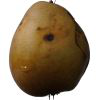

In [53]:
image = dataset["test"][0]["image"]

image

In [54]:
pipe(image)

[{'label': 'Pear 3', 'score': 0.9716227650642395},
 {'label': 'Papaya 1', 'score': 0.6763075590133667},
 {'label': 'Apple hit 1', 'score': 0.6577134728431702},
 {'label': 'Nut Forest 1', 'score': 0.6147046089172363},
 {'label': 'Tomato 1', 'score': 0.613632321357727}]

In [55]:
# actual label
dataset["test"][0]["label"]

'Pear 3'